In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
from probabilistic_vq.vector_quantizer import VectorQuantizer
from probabilistic_vq import pass_through
from probabilistic_vq import kl_divergence

In [3]:
class Model(tf.keras.models.Model):
    
    def __init__(self, **kwargs):
        """Build a model using a probabilistic vector quantized hidden layer
        """
        tf.keras.models.Model.__init__(self, **kwargs)
        kwargs = dict(strides=(2, 2), padding='same')
        
        self.conv_layers = []
        self.conv_transpose_layers = []
        
        self.vq = VectorQuantizer(10, 128)
        for i in range(3):
            self.conv_layers.append(
                tf.keras.layers.Conv2D(
                    32 * (2 ** i), 5 if i % 2  == 0 else 4, **kwargs))
            
            self.conv_transpose_layers.append(
                tf.keras.layers.Conv2DTranspose(
                    64 // (2 ** i) if i < 2 else 3, 5 if i % 2  == 0 else 4, **kwargs))
        
    def call(self, images, **kwargs):
        """Forward pass using probabilistic vector quantization on a 
        discrete latent variable model
        
        Arguments:
        images: float32 tensor with shape [batch_dim, height, width, color_dim]
        
        Returns:
        float32 tensor with shape [batch_dim, height, width, color_dim]
        float32 tensor with shape [,]
        """
        x = images
        for i in range(3):
            x = self.conv_layers[i](
                tf.nn.relu(x) if i > 0 else x, **kwargs)
            
        logits = self.vq(x, **kwargs)
        x = pass_through(
            x, self.vq.sample(logits, **kwargs))
        
        for i in range(3):
            x = self.conv_transpose_layers[i](
                tf.nn.relu(x) if i > 0 else x, **kwargs)

        log_p = tf.math.log_softmax(logits)
        uniform_log_p = -tf.math.log(
            tf.fill(tf.shape(logits), tf.cast(tf.shape(logits)[-1], tf.float32)))
        
        return (tf.nn.tanh(x), 
                tf.reduce_mean(kl_divergence(log_p, uniform_log_p)))

In [4]:
model = Model()

In [5]:
dataset = tfds.load(name="cifar10", split="train")
dataset = dataset.repeat(100).shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
optim = tf.keras.optimizers.Adam()

In [7]:
def loss_function(images):
    x, kl_loss = model(images)
    return kl_loss + tf.reduce_mean(
        tf.keras.losses.mean_squared_error(images, x))

MSE: 0.27654018998146057, KL: 8.227307989727706e-05


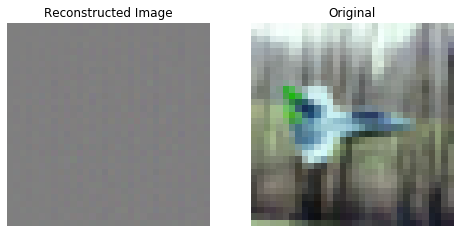

MSE: 0.2732257843017578, KL: 2.9726350021519465e-06


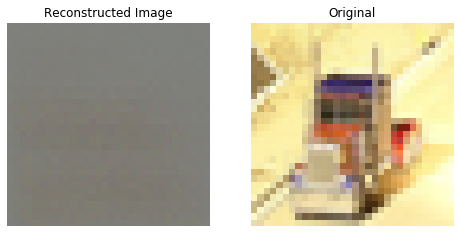

MSE: 0.250998318195343, KL: 6.760616315659718e-07


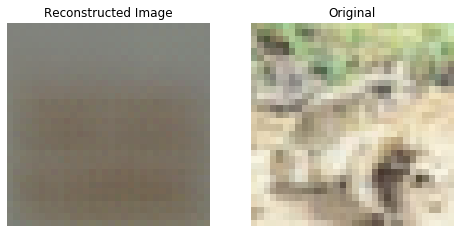

MSE: 0.23985078930854797, KL: 1.2986539559278754e-06


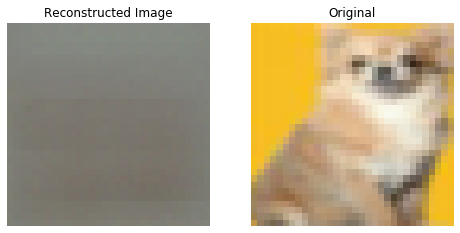

MSE: 0.2577595114707947, KL: 1.416469422110822e-05


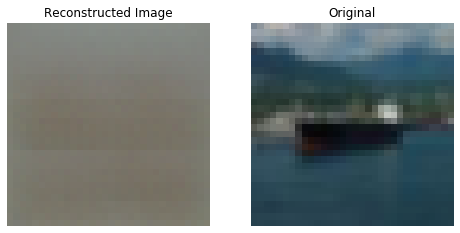

MSE: 0.216205433011055, KL: 3.488747461233288e-05


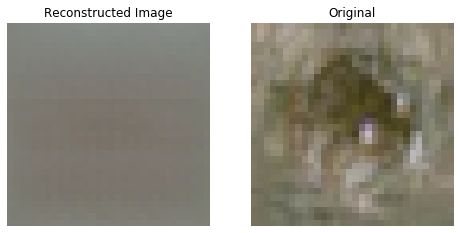

MSE: 0.2459527850151062, KL: 6.966271757846698e-05


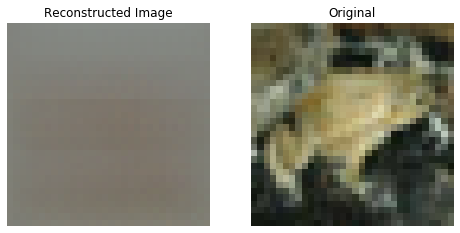

MSE: 0.2175603210926056, KL: 0.00010081108484882861


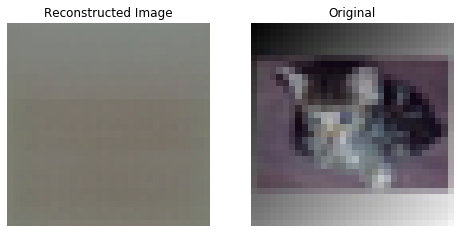

MSE: 0.20407244563102722, KL: 0.00014831576845608652


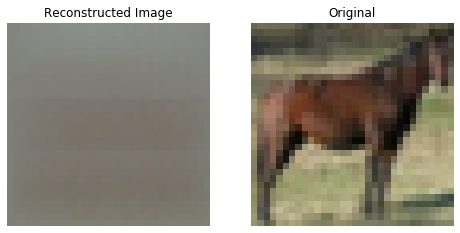

MSE: 0.2730729579925537, KL: 0.0002238816668977961


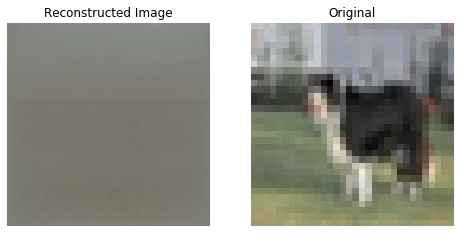

MSE: 0.2564965784549713, KL: 0.00023692366085015237


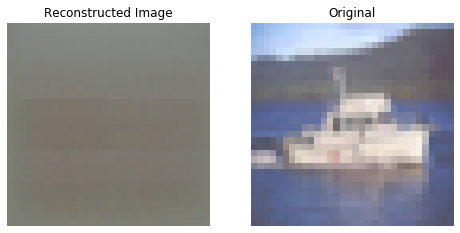

MSE: 0.3090817630290985, KL: 0.00020852104353252798


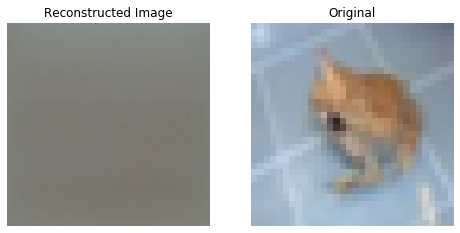

MSE: 0.225355327129364, KL: 0.00022116763284429908


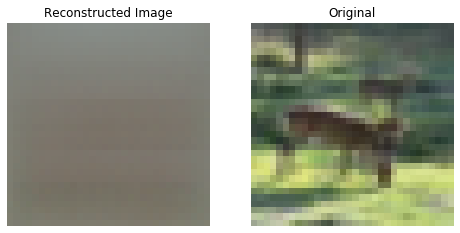

MSE: 0.262591153383255, KL: 0.00030415182118304074


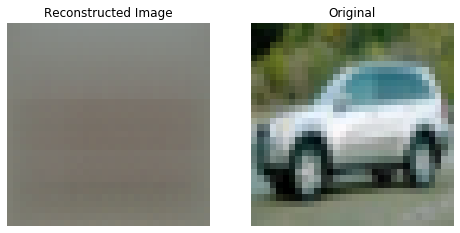

MSE: 0.26870325207710266, KL: 0.00032325772917829454


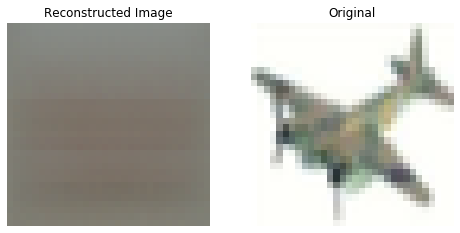

MSE: 0.2855224609375, KL: 0.0002481530827935785


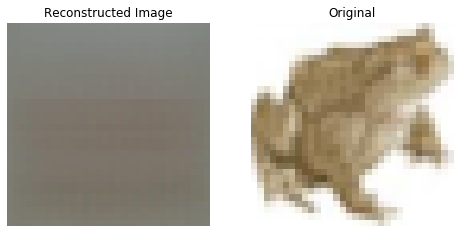

MSE: 0.24404241144657135, KL: 0.00018532236572355032


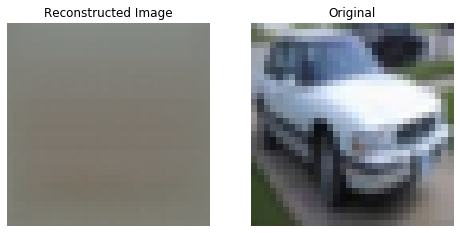

MSE: 0.23636707663536072, KL: 0.0003571716952137649


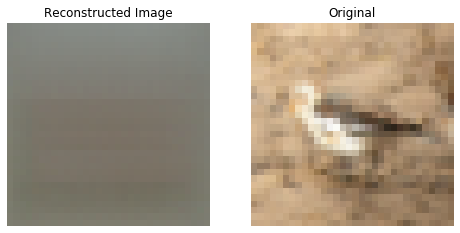

MSE: 0.23209457099437714, KL: 0.00016922960639931262


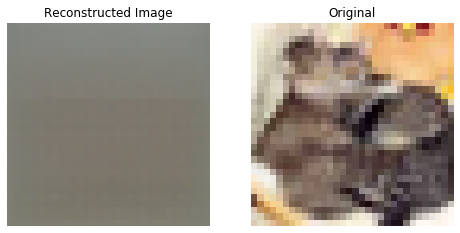

MSE: 0.19692711532115936, KL: 0.0002120204590028152


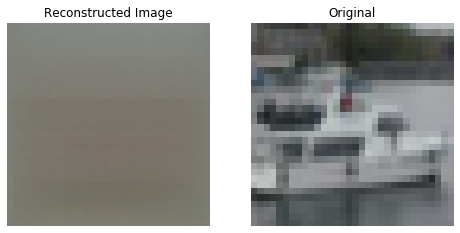

MSE: 0.2107647955417633, KL: 0.00035577878588810563


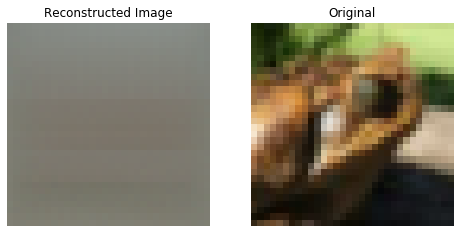

MSE: 0.2507725656032562, KL: 0.00014719109458383173


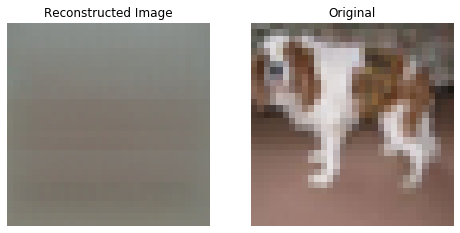

In [ ]:
for i, batch in enumerate(dataset):
    images = batch["image"]
    images = tf.cast(images, tf.float32) / 255.0 * 2.0 - 1.0
    optim.minimize(lambda: loss_function(images), model.trainable_variables)
    
    if i % 100 == 0:
        x, kl_loss = model(images)
        print("MSE: {}, KL: {}".format(
            tf.reduce_mean(tf.keras.losses.mean_squared_error(images, x)), kl_loss))
        
        fig = plt.figure(figsize=(8, 8))
        axes = fig.add_subplot(1, 2, 1)
        axes.set_title("Reconstructed Image")
        axes.set_axis_off()
        plt.imshow(x[0] * 0.5 + 0.5)
        
        axes = fig.add_subplot(1, 2, 2)
        axes.set_title("Original")
        plt.imshow(images[0] * 0.5 + 0.5)
        axes.set_axis_off()
        plt.show()